##  Piza Nava Vladimir - 111-494


## Laboratorio 3.1

## Link al repositorio: https://github.com/vladi-13/Laboratorios/blob/main/Laboratorio%203-1.ipynb

## Link al dataset: https://www.kaggle.com/datasets/vladi13/dataset-flores-piza-nava-vladimir

Este código configura el entorno para entrenar una red neuronal en **PyTorch** utilizando **DirectML**, una alternativa a CUDA para GPUs AMD.  

###  Configuración del Dispositivo  
Se obtiene el dispositivo disponible con **DirectML** y se fija una semilla aleatoria (`torch.manual_seed(42)`) para asegurar que los experimentos sean reproducibles.  

###  Mensaje de Confirmación  
Se imprime el dispositivo en uso para verificar que DirectML está funcionando correctamente.  

In [28]:
import torch
import torch_directml
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Configurar el dispositivo DirectML
device = torch_directml.device()
torch.manual_seed(42)  # Para reproducibilidad

print(f"Usando dispositivo: {device}")

Usando dispositivo: privateuseone:0


# Explicación General del Código  

- **Carga del dataset** desde un CSV con rutas de imágenes y etiquetas.  
- **Mapeo de clases** a índices numéricos para la red neuronal.  
- **División 80/20** en entrenamiento y validación con estratificación.  
- **Transformaciones**: redimensionado (64x64), conversión a tensor y normalización.  
- **Dataset personalizado** (`FlowerDataset`) para cargar imágenes y aplicar transformaciones.  
- **DataLoaders** para manejar datos en lotes (`batch_size=256`), con mezcla en entrenamiento.  
- **Impresión de datos** para verificar la cantidad en cada conjunto.  

In [29]:
# Cargar dataset
csv_path = "dataset_flores.csv"
data = pd.read_csv(csv_path)

# Crear un mapeo de clases a índices numéricos
class_mapping = {name: idx for idx, name in enumerate(sorted(data.iloc[:, 1].unique()))}
print("Mapa de clases:", class_mapping)  # Verificar mapeo

# División del dataset en 80% entrenamiento y 20% validación
train_data, val_data = train_test_split(
    data, test_size=0.2, stratify=data.iloc[:, 1], random_state=42
)

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tamaño para DenseNet161
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class FlowerDataset(Dataset):
    def __init__(self, csv_data, transform=None):
        self.data = csv_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index, 0]  # Ruta de la imagen
        label = self.data.iloc[index, 1]     # Clase de la imagen
        label = class_mapping[label]         # Convertir la clase a índice numérico

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# Crear dataset de entrenamiento y validación
train_dataset = FlowerDataset(train_data, transform=transform)
val_dataset = FlowerDataset(val_data, transform=transform)

# DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

# Mostrar la división de los datos
print(f"Datos de entrenamiento: {len(train_dataset)}")
print(f"Datos de validación: {len(val_dataset)}")

Mapa de clases: {'Astromelia': 0, 'Cartucho': 1, 'Chapulin': 2, 'Lirio': 3, 'Obispo': 4}
Datos de entrenamiento: 40000
Datos de validación: 10000


#  Explicación del Código  

### 1️ Carga del Modelo Preentrenado  
Se importa `torchvision.models` y se carga **DenseNet161**, un modelo preentrenado en **ImageNet**. Esto permite reutilizar características aprendidas en un gran dataset sin necesidad de entrenar desde cero.  

### 2️ Congelación de Capas  
Se itera sobre los parámetros del modelo y se establece `requires_grad = False`, evitando que las capas convolucionales se actualicen durante el entrenamiento. Esto es clave en **Transfer Learning**, ya que solo se ajustará la última capa.  

### 3️ Modificación de la Capa de Clasificación  
DenseNet161 originalmente clasifica **1,000 clases**. Se reemplaza la última capa (`classifier`) con una nueva `nn.Linear()` configurada para **5 clases**, que es el número de categorías en este problema.  

### 4️ Envío del Modelo a DirectML  
Se mueve el modelo al dispositivo de procesamiento (DirectML) para aprovechar la aceleración por GPU.  

### 5️ Impresión del Modelo  
Se imprime la arquitectura del modelo para verificar los cambios realizados.  

In [ ]:
import torchvision.models as models

# Cargar modelo preentrenado
model = models.densenet161(pretrained=True)

# Congelar capas convolucionales
for param in model.parameters():
    param.requires_grad = False # No actualizar los pesos

# Modificar la capa final para 5 clases
model.classifier = nn.Linear(model.classifier.in_features, 5)

# Enviar modelo a DirectML
model = model.to(device)
print(model)

c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorio\Laboratorio 3\entorno\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorio\Laboratorio 3\entorno\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

# Explicación del código

Este código configura el entrenamiento de un modelo en PyTorch utilizando la función de pérdida **CrossEntropyLoss** y el optimizador **Adam**, que ajusta los parámetros del modelo durante el entrenamiento.

- **Función de pérdida**: **CrossEntropyLoss** se usa para medir la diferencia entre las predicciones del modelo y las etiquetas verdaderas.
- **Optimizador**: **Adam** ajusta los parámetros del modelo, y se aplica solo al clasificador con una tasa de aprendizaje de 0.001.

Además, se implementa **early stopping** para evitar el sobreajuste:
- **`epochs`** define el número de épocas (10 en este caso).
- **`patience`** (2) controla cuántas épocas sin mejora en la pérdida de validación se permiten antes de detener el entrenamiento.
- **`best_val_loss`** y **`early_stop_counter`** gestionan la lógica de detención temprana.

Este código asegura que el modelo se entrene eficientemente sin sobreajustarse.

In [31]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Parámetros para entrenamiento y early stopping
epochs = 10
patience = 2  # Si la pérdida de validación no mejora en 5 épocas, se detiene
best_val_loss = float("inf")
early_stop_counter = 0

# Explicación del código

Este código entrena y valida un modelo de aprendizaje profundo con **early stopping** en PyTorch.

## 1. Entrenamiento

- **`model.train()`**: El modelo se pone en modo entrenamiento.
- **Cálculo de pérdida**: Se calcula la pérdida con `CrossEntropyLoss` y se realiza la retropropagación con `loss.backward()`.
- **Optimización**: Se actualizan los parámetros del modelo con `optimizer.step()`.
- **Precisión**: Se calcula la precisión de entrenamiento comparando las predicciones con las etiquetas verdaderas.

## 2. Validación

- **`model.eval()`**: El modelo se pone en modo evaluación para evitar actualizaciones de pesos.
- **Cálculo de pérdida de validación**: Similar al entrenamiento, pero sin retropropagación.

## 3. Early Stopping

- Si la pérdida de validación mejora, se guarda el modelo y se reinicia el contador de **early stopping**.
- Si no mejora después de `patience` épocas, se detiene el entrenamiento antes de terminar todas las épocas.

Este código entrena y valida el modelo, calcula métricas de desempeño y aplica **early stopping** para evitar el sobreajuste.

In [33]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()

    # Usar tqdm para el DataLoader de entrenamiento
    train_loader_tqdm = tqdm(train_loader, desc=f"Época {epoch+1}/{epochs} [Entrenando]", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        # Actualizar barra de progreso
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Usar tqdm para el DataLoader de validación
    val_loader_tqdm = tqdm(val_loader, desc=f"Época {epoch+1}/{epochs} [Validando]", leave=False)

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            # Actualizar barra de progreso
            val_loader_tqdm.set_postfix(loss=loss.item())

    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(val_loader)

    # Mostrar métricas de la época
    print(f"\n--- Época {epoch+1}/{epochs} ---")
    print(f"  🏋️ Pérdida Entrenamiento: {train_loss:.4f}, Precisión: {train_accuracy:.2f}%")
    print(f"  🧪 Pérdida Validación: {val_loss:.4f}, Precisión: {val_accuracy:.2f}%")
    print(f"  ⏱️ Tiempo: {time.time() - start_time:.2f} segundos")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model_2.pth")  # Guardar el mejor modelo
        print("  🔥 Nuevo mejor modelo guardado!")
    else:
        early_stop_counter += 1
        print(f"  ⏳ Early Stopping Counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("\n🚨 Deteniendo entrenamiento por Early Stopping 🚨")
        break


--- Época 1/10 ---
  🏋️ Pérdida Entrenamiento: 0.0979, Precisión: 98.12%
  🧪 Pérdida Validación: 0.0737, Precisión: 98.36%
  ⏱️ Tiempo: 589.71 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 2/10 ---
  🏋️ Pérdida Entrenamiento: 0.0609, Precisión: 98.78%
  🧪 Pérdida Validación: 0.0564, Precisión: 98.61%
  ⏱️ Tiempo: 533.76 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 3/10 ---
  🏋️ Pérdida Entrenamiento: 0.0469, Precisión: 98.94%
  🧪 Pérdida Validación: 0.0486, Precisión: 98.66%
  ⏱️ Tiempo: 522.59 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 4/10 ---
  🏋️ Pérdida Entrenamiento: 0.0384, Precisión: 99.17%
  🧪 Pérdida Validación: 0.0458, Precisión: 98.65%
  ⏱️ Tiempo: 520.01 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 5/10 ---
  🏋️ Pérdida Entrenamiento: 0.0331, Precisión: 99.29%
  🧪 Pérdida Validación: 0.0410, Precisión: 98.67%
  ⏱️ Tiempo: 516.18 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 6/10 ---
  🏋️ Pérdida Entrenamiento: 0.0295, Precisión: 99.30%
  🧪 Pérdida Validación: 0.0399, Precisión: 98.73%
  ⏱️ Tiempo: 527.05 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 7/10 ---
  🏋️ Pérdida Entrenamiento: 0.0268, Precisión: 99.39%
  🧪 Pérdida Validación: 0.0367, Precisión: 98.83%
  ⏱️ Tiempo: 542.96 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 8/10 ---
  🏋️ Pérdida Entrenamiento: 0.0249, Precisión: 99.37%
  🧪 Pérdida Validación: 0.0367, Precisión: 98.77%
  ⏱️ Tiempo: 550.37 segundos
  ⏳ Early Stopping Counter: 1/2



--- Época 9/10 ---
  🏋️ Pérdida Entrenamiento: 0.0232, Precisión: 99.45%
  🧪 Pérdida Validación: 0.0350, Precisión: 98.86%
  ⏱️ Tiempo: 550.84 segundos
  🔥 Nuevo mejor modelo guardado!



--- Época 10/10 ---
  🏋️ Pérdida Entrenamiento: 0.0212, Precisión: 99.46%
  🧪 Pérdida Validación: 0.0345, Precisión: 98.88%
  ⏱️ Tiempo: 542.75 segundos
  🔥 Nuevo mejor modelo guardado!


# Explicación del Código

Este código carga un modelo preentrenado y lo evalúa en un conjunto de validación.

1. **Cargar el modelo guardado**:
   - `model.load_state_dict(torch.load("best_model_2.pth", map_location=device))`: Carga los pesos del modelo guardado.
   - `model.eval()`: Pone el modelo en modo evaluación, desactivando gradientes y capas como dropout.

2. **Evaluación del modelo**:
   - `evaluar_modelo` itera sobre el conjunto de validación (`val_loader`), calcula la pérdida y la precisión del modelo.
   - Se usa `torch.no_grad()` para evitar el cálculo de gradientes y ahorrar memoria.
   - La función devuelve la **precisión** y la **pérdida promedio**.

3. **Mostrar resultados**:
   - Al final, se imprime la **precisión** y la **pérdida promedio** del modelo.

Este código permite evaluar el rendimiento de un modelo preentrenado sin modificar sus parámetros.

In [34]:
# Cargar el modelo guardado
model.load_state_dict(torch.load("best_model_2.pth", map_location=device))  # Cargar los pesos del modelo
model.eval()  # Modo evaluación, desactiva gradientes

# Función de evaluación
def evaluar_modelo(model, val_loader, criterion, device):
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No calcular gradientes
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total  # Precisión
    avg_loss = total_loss / len(val_loader)  # Pérdida promedio

    # Mostrar los resultados
    print(f'Precisión: {accuracy:.2f}% - Pérdida Promedio: {avg_loss:.4f}')
    return accuracy, avg_loss

# Evaluar el modelo cargado
accuracy, loss = evaluar_modelo(model, train_loader, criterion, device)

C:\Users\vladi\AppData\Local\Temp\ipykernel_21928\529747373.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_2.pth", map_loca

Precisión: 99.72% - Pérdida Promedio: 0.0154


# Explicación del Código

Este código carga un modelo preentrenado, selecciona una imagen aleatoria desde un archivo CSV y predice su clase utilizando el modelo.

1. **Lista de clases**:
   - `class_names` contiene los nombres de las clases del modelo (por ejemplo, flores de diferentes tipos).

2. **Seleccionar imagen aleatoria**:
   - `elegir_imagen_aleatoria` carga un archivo CSV con las rutas de las imágenes y sus etiquetas, y selecciona aleatoriamente una imagen.

3. **Predecir una imagen**:
   - `predecir_imagen` carga una imagen, la transforma a tensor y la pasa por el modelo para obtener la predicción.
   - Se devuelve la imagen y la clase predicha.

4. **Evaluación**:
   - El modelo se carga con `model.load_state_dict()` y se pone en modo evaluación.
   - Se predice la clase de la imagen seleccionada aleatoriamente y se muestra la imagen junto con la predicción y la clase real.

Este código permite predecir la clase de una imagen aleatoria usando un modelo previamente entrenado.

C:\Users\vladi\AppData\Local\Temp\ipykernel_21928\1510294640.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_2.pth", map_lo

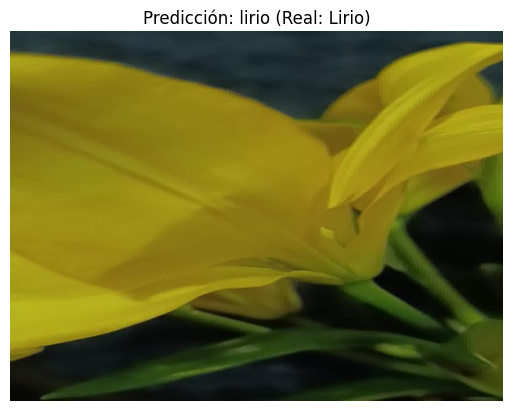

In [49]:
# Lista de clases
class_names = ["astromelia", "cartucho", "chapulin", "lirio", "obispo"]

# Función para seleccionar una imagen aleatoria desde el CSV
def elegir_imagen_aleatoria(csv_path="dataset_flores.csv"):
    """Selecciona aleatoriamente una imagen desde un CSV con rutas y clases."""
    df = pd.read_csv(csv_path)
    
    if df.empty:
        return None, None
    
    fila = df.sample(n=1).iloc[0]  # Seleccionar una fila aleatoria
    return fila["image_path"], fila["label"]

# Función para predecir una imagen usando el modelo
def predecir_imagen(model, image_path, class_names, device):
    """Carga una imagen, la pasa por el modelo y devuelve la predicción."""
    image = Image.open(image_path).convert("RGB")  # Cargar la imagen
    image_tensor = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones a la imagen

    model.eval()
    with torch.no_grad():  # No calcular gradientes
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    prediccion = class_names[predicted.item()]  # Convertir índice a nombre de clase
    return image, prediccion

# Cargar el modelo guardado
model.load_state_dict(torch.load("best_model_2.pth", map_location=device))
model.eval()  # Cambiar a modo evaluación

# Predecir una imagen aleatoria desde el CSV
image_path, clase_real = elegir_imagen_aleatoria()
if image_path:
    image, prediccion = predecir_imagen(model, image_path, class_names, device)

    # Mostrar la imagen con su predicción y clase real
    plt.imshow(image)
    plt.title(f'Predicción: {prediccion} (Real: {clase_real})')
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron imágenes en el CSV.")